# Recreates WGAN-GP model in Chapter 4 of "Generative Deep Learning" by Foster (Ganimals)

# Get Quickdraw "Ganimals" data

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

from google.colab import drive

import torch
from torch.nn.modules.transformer import Transformer
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [ ]:
# download camel numpy file from Google quickdraw https://bit.ly/30HyNqg
drive.mount('/content/drive/')
data = np.load('/content/drive/My Drive/Data/camel/full_numpy_bitmap_camel.npy')
print(f'Number of images: {data.shape[0]}')
print(f'Shape of images: {data[0].shape}')



Mounted at /content/drive/
Number of images: 121399
Shape of images: (784,)


In [ ]:

class ganimal_data(Dataset):
    def __init__(self, np_array, transform=None):
        self.images = np_array
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, i):
        img = self.images[i].reshape((28,28))
        if self.transform:
            img = self.transform(img)
        return (2 * img / 1) - 1 # scale [0,1] to [-1,1]
        return img


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(28),
])

trn_dataset = ganimal_data(data, transform)
trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=True, num_workers=1)

# Visualize images

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


num images: 121399
shape of each images: torch.Size([1, 28, 28])


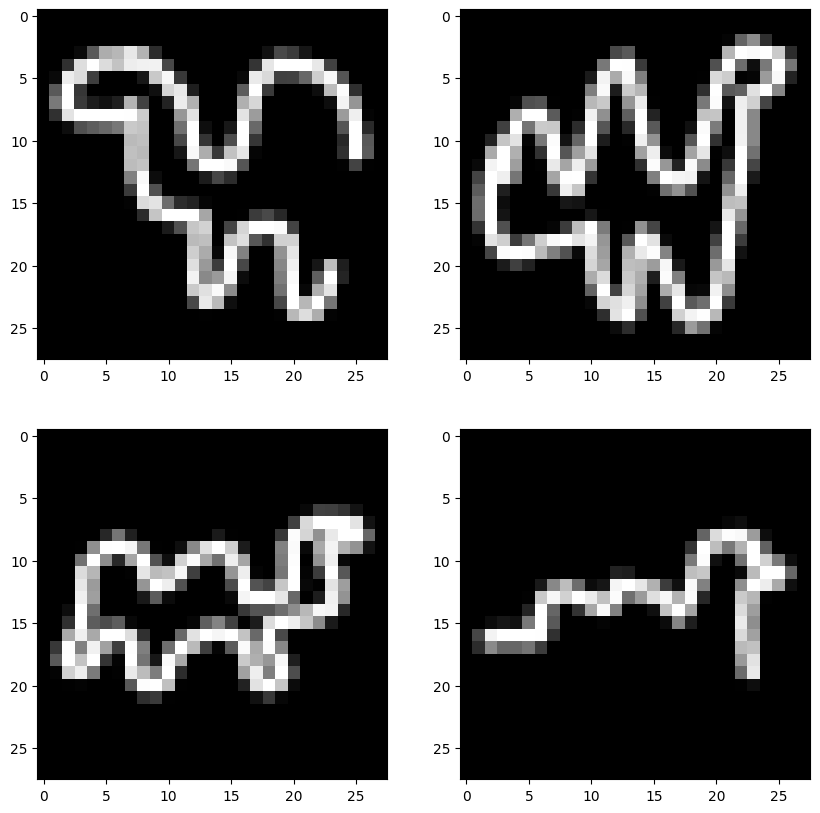

In [ ]:
images_iter = iter(trn_dataloader)
images = next(images_iter)

print(f'num images: {len(trn_dataset)}')
print(f'shape of each images: {images[0].shape}' )

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(images[0].squeeze(0), cmap='gray')
ax[0,1].imshow(images[1].squeeze(0), cmap='gray')
ax[1,0].imshow(images[2].squeeze(0), cmap='gray')
ax[1,1].imshow(images[3].squeeze(0), cmap='gray')
plt.show()


# Model architecture for Discriminator




In [ ]:

class Discriminator(nn.Module):

  def __init__(self, in_channels, out_channels, disc_conv_filters, 
               disc_conv_strides, disc_conv_padding, dropout):
     super(Discriminator, self).__init__()
     self.conv1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=disc_conv_filters[0], 
                       stride=disc_conv_strides[0], padding=disc_conv_padding[0])
     self.conv2 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=disc_conv_filters[1], 
                       stride=disc_conv_strides[1], padding=disc_conv_padding[0])
     self.conv3 = nn.Conv2d(out_channels[1], out_channels[2], kernel_size=disc_conv_filters[2], 
                       stride=disc_conv_strides[2], padding=disc_conv_padding[0])     
     self.conv4 = nn.Conv2d(out_channels[2], out_channels[3], kernel_size=disc_conv_filters[3], 
                       stride=disc_conv_strides[3], padding=disc_conv_padding[0]) 
     self.flat = nn.Flatten()   
     self.linear = nn.Linear(2048, 1) 
     self.dropout = nn.Dropout(dropout)


  def forward(self, x):
    x = self.dropout(torch.relu(self.conv1(x)))
    x = self.dropout(torch.relu(self.conv2(x)))
    x = self.dropout(torch.relu(self.conv3(x)))
    x = self.dropout(torch.relu(self.conv4(x)))
    x = self.flat(x)
    x = self.linear(x) # WGAN: remove sigmoid activation, now discriminator is a critic
    return x



disc_conv_filters = [5,5,5,5]
disc_conv_strides = [2,2,2,1]
disc_conv_channels = [64, 64, 128, 128]
disc_conv_padding = [2,1,1,1]
dropout=0.4
disc_in_channels=1
torch.random.manual_seed(10210)

my_discriminator = Discriminator(in_channels=disc_in_channels, 
                                 out_channels=disc_conv_channels, 
                                 disc_conv_filters=disc_conv_filters, 
                                 disc_conv_strides=disc_conv_strides,
                                 disc_conv_padding=disc_conv_padding, 
                                 dropout=dropout)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
my_discriminator.to(device)

summary(my_discriminator, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
           Dropout-2           [-1, 64, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]         102,464
           Dropout-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 4, 4]         204,928
           Dropout-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 128, 4, 4]         409,728
           Dropout-8            [-1, 128, 4, 4]               0
           Flatten-9                 [-1, 2048]               0
           Linear-10                    [-1, 1]           2,049
Total params: 720,833
Trainable params: 720,833
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 2.75
Estimated T

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_dim, gen_conv_filters, gen_conv_strides, 
               gen_conv_channels, gen_conv_padding, gen_upsample, dropout, momentum, initial_image_size):
      super(Generator, self).__init__()
      self.initial_image_size=initial_image_size
      self.linear1 = nn.Linear(input_dim, 3136)
      self.batch_norm1 = nn.BatchNorm1d(3136, momentum=momentum)
      self.upsample1 = nn.Upsample((gen_initial_size*gen_upsample[0], 
                                    gen_initial_size*gen_upsample[0]))
      self.conv2 = nn.Conv2d(64, gen_conv_channels[0], kernel_size=gen_conv_filters[0], 
                             stride=gen_conv_strides[0], 
                             padding=gen_conv_padding[0])
      self.batch_norm2 = nn.BatchNorm2d(gen_conv_channels[0], momentum=momentum)
      self.upsample2 = nn.Upsample((28,28))
      self.conv3 = nn.Conv2d(gen_conv_channels[0], gen_conv_channels[1], kernel_size=gen_conv_filters[1], 
                             stride=gen_conv_strides[1], 
                             padding=gen_conv_padding[1])
      self.batch_norm3 = nn.BatchNorm2d(gen_conv_channels[1], momentum=momentum)
      self.conv4 = nn.Conv2d(gen_conv_channels[1], gen_conv_channels[2], kernel_size=gen_conv_filters[2], 
                             stride=gen_conv_strides[2], 
                             padding=gen_conv_padding[2])
      self.batch_norm4 = nn.BatchNorm2d(gen_conv_channels[2], momentum=momentum)
      self.conv5 = nn.Conv2d(gen_conv_channels[2], gen_conv_channels[3], kernel_size=gen_conv_filters[3], 
                             stride=gen_conv_strides[3], 
                             padding=gen_conv_padding[3])
      self.dropout = nn.Dropout(dropout)


  def forward(self, x):
      x = torch.relu(self.batch_norm1(self.linear1(x)))
      x = torch.reshape(x, (-1,64,self.initial_image_size, self.initial_image_size))
      x = self.dropout(x)
      x = self.upsample1(x)

      x = torch.relu(self.batch_norm2(self.conv2(x)))
      x = self.upsample2(x)

      x = torch.relu(self.batch_norm3(self.conv3(x)))
      x = torch.relu(self.batch_norm4(self.conv4(x)))
      x = torch.tanh(self.conv5(x))

      return x
      

gen_conv_filters = [5,5,5,5]
gen_conv_strides = [1,1,1,1]
gen_conv_channels = [128,64,64,1]
gen_conv_padding = [2,2,2,2]
gen_upsample=[2,2,1,1]
gen_dropout=0.4
gen_input_dim=100
gen_momentum=0.9
gen_initial_size=7
torch.random.manual_seed(10210)
my_generator = Generator(input_dim=gen_input_dim, 
                         gen_conv_filters=gen_conv_filters, 
                         gen_conv_strides=gen_conv_strides, 
                         gen_conv_channels=gen_conv_channels, 
                         gen_conv_padding=gen_conv_padding, 
                         gen_upsample=gen_upsample,
                         dropout=gen_dropout,
                         momentum=gen_momentum,
                         initial_image_size=gen_initial_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
my_generator.to(device)

x = torch.randn((5,100)).to(device)
x = my_generator(x)
print(x.shape)
summary(my_generator, input_size=tuple([100]))

torch.Size([5, 1, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         316,736
       BatchNorm1d-2                 [-1, 3136]           6,272
           Dropout-3             [-1, 64, 7, 7]               0
          Upsample-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]         204,928
       BatchNorm2d-6          [-1, 128, 14, 14]             256
          Upsample-7          [-1, 128, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]         204,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10           [-1, 64, 28, 28]         102,464
      BatchNorm2d-11           [-1, 64, 28, 28]             128
           Conv2d-12            [-1, 1, 28, 28]           1,601
Total params: 837,377
Trainable params: 837,377
Non-trainable params: 0
----

# Training

In [ ]:
def plot_images(gen_images, num_to_show=5):
  fig, ax = plt.subplots(1, num_to_show, figsize=(13,5))
  for i in range(num_to_show):
      ax[i].imshow(gen_images[i].squeeze(0).cpu().detach().numpy(), cmap='gray')
  plt.show()


# min -E[D(real) - D(fake)] 
def wasserstein_loss(y_pred, y_true):
  return -torch.mean(y_pred * y_true)

def bce_loss(y_pred, y_true):
  return -torch.mean(y_pred.log()*y_true + (1-y_true)*(1-y_pred).log())

# based on https://youtu.be/pG0QZ7OddX4
def gradient_penalty(disc, real, fake, device="cpu"):
  bs, c, h, w = real.shape
  epsilon = torch.rand(bs, 1, 1, 1).repeat(1, c, h, w).to(device)
  interpolated_images = real * epsilon + fake * (1-epsilon)
  yhat = disc(interpolated_images)

  gradient = torch.autograd.grad(
      inputs=interpolated_images,
      outputs=yhat,
      grad_outputs=torch.ones_like(yhat),
      create_graph=True,
      retain_graph=True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm-1)**2)
  return gradient_penalty


cuda


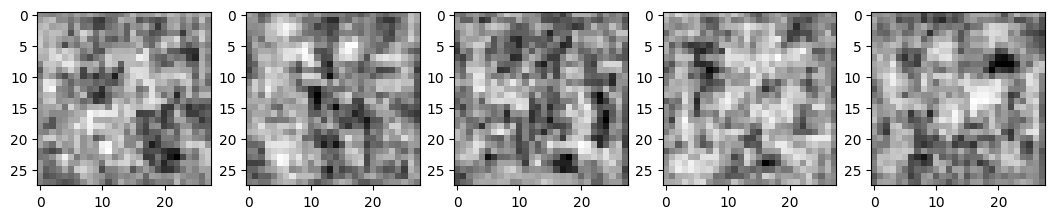

epoch: 0:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 0
Avg Training Disc Loss : -0.049870770498036815
Avg Training Gen Loss : -0.07590599861512229




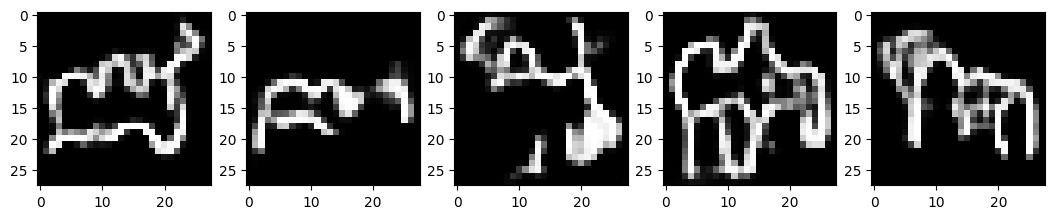

epoch: 1:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 1
Avg Training Disc Loss : -0.030737055740513244
Avg Training Gen Loss : -0.02699491015908593




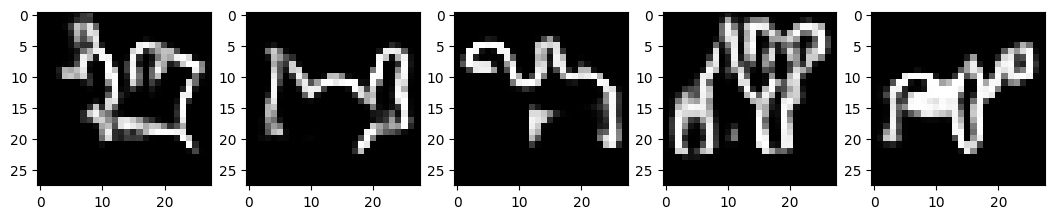

epoch: 2:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 2
Avg Training Disc Loss : -0.02724921901762598
Avg Training Gen Loss : -0.015664664062723245




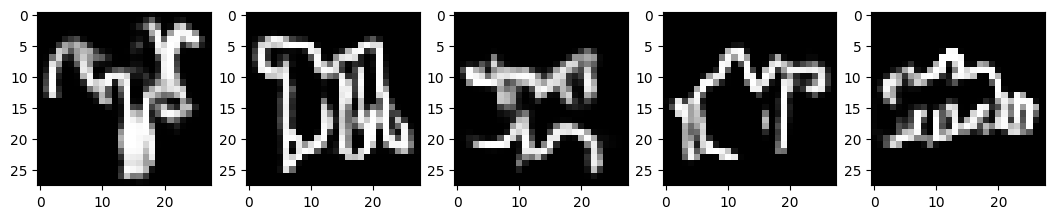

epoch: 3:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 3
Avg Training Disc Loss : -0.02509436315949907
Avg Training Gen Loss : -0.004031794186025159




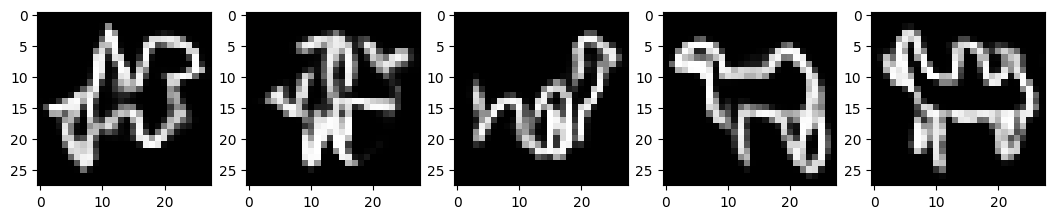

epoch: 4:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 4
Avg Training Disc Loss : -0.02252034062074426
Avg Training Gen Loss : 0.0001261830424102066




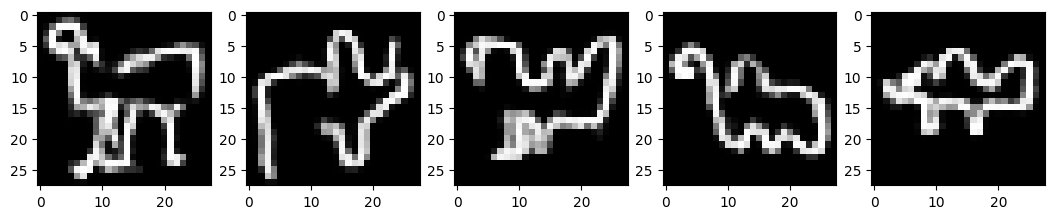

epoch: 5:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 5
Avg Training Disc Loss : -0.02101190423565599
Avg Training Gen Loss : 0.004308236740955893




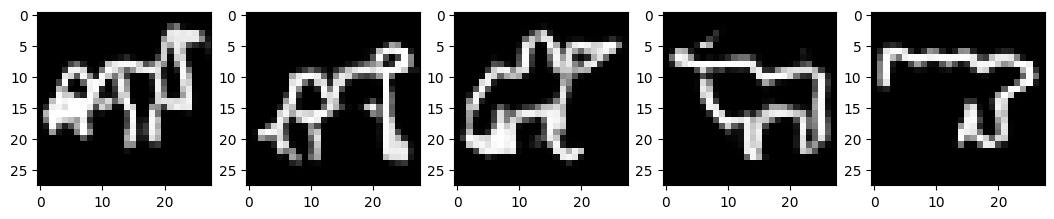

epoch: 6:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 6
Avg Training Disc Loss : -0.01763660385860419
Avg Training Gen Loss : -0.018754314456771868




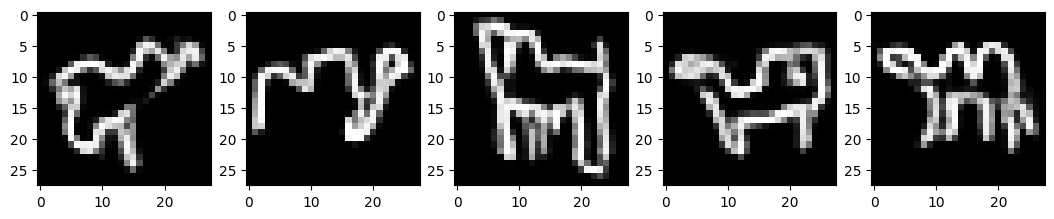

epoch: 7:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 7
Avg Training Disc Loss : -0.0152952593611299
Avg Training Gen Loss : -0.02957812815723783




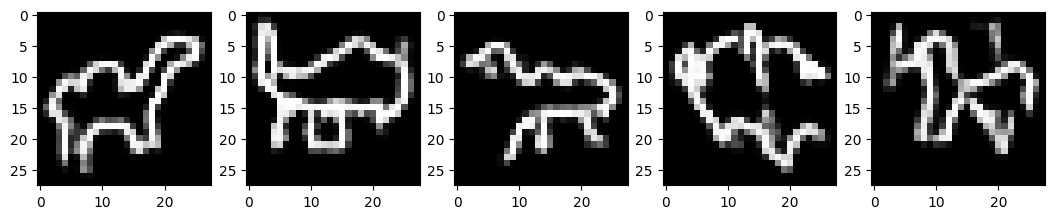

epoch: 8:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 8
Avg Training Disc Loss : -0.014558063629150807
Avg Training Gen Loss : -0.032881857578063715




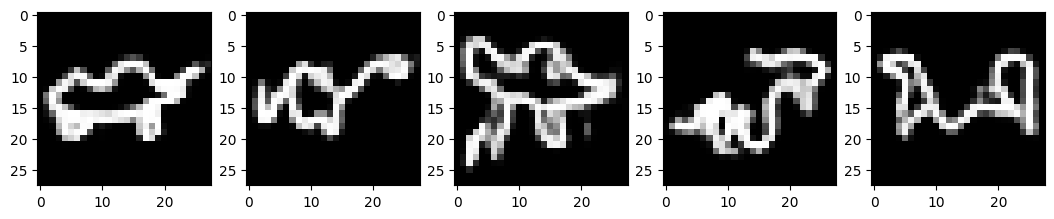

epoch: 9:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 9
Avg Training Disc Loss : -0.01367247475723876
Avg Training Gen Loss : -0.03319943829865683




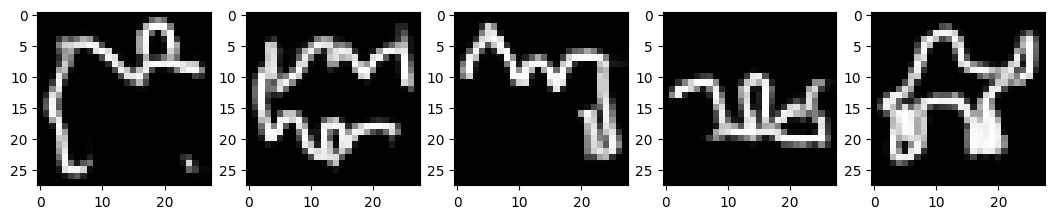

epoch: 10:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 10
Avg Training Disc Loss : -0.012101985560316218
Avg Training Gen Loss : -0.005479062242225422




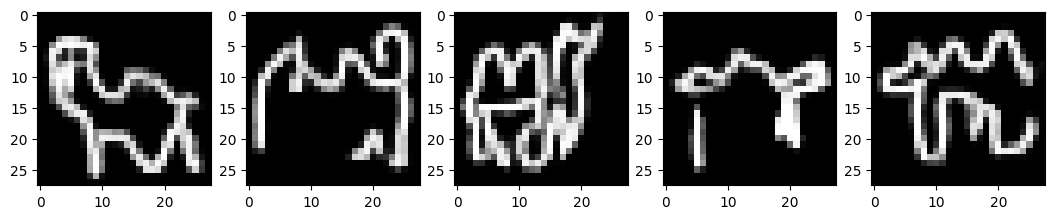

epoch: 11:   0%|          | 0/1897 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Epoch: 11
Avg Training Disc Loss : -0.011907131612230417
Avg Training Gen Loss : -0.006647931666635664




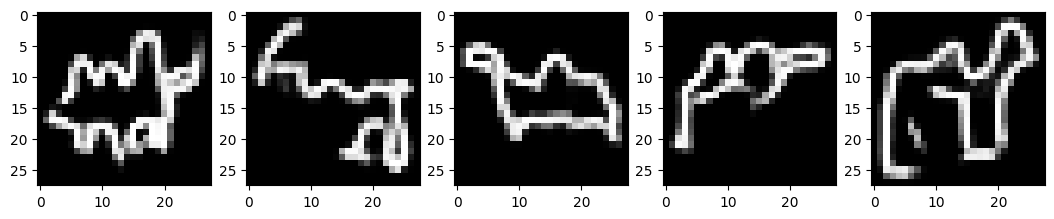

In [ ]:
from torch.optim import Adam, RMSprop

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
my_descriminator = my_discriminator.to(device)
my_generator = my_generator.to(device)


lr_disc=1e-4 # WGAN-GP: from paper
optimizer_disc = Adam(my_descriminator.parameters(), lr=lr_disc, betas=(0.0,0.9)) # WGAN-GP: use Adam
lr_gen=1e-4 # WGAN-GP: from paper
optimizer_gen = Adam(my_generator.parameters(), lr=lr_gen, betas=(0.0,0.9)) # WGAN-GP: use Adam


criterion_disc = wasserstein_loss   # WGAN: use Wasserstein_loss and not BCE
criterion_gen = wasserstein_loss    # WGAN: use Wasserstein_loss and not BCE
torch.random.manual_seed(10210)

epochs = 12
disc_iter_per_gen_batch = 5      # WGAN: train the discriminator to convergence on each batch
#weight_clip = 0.01              # WGAN-GP: no more clipping to enforce 1-Lipshitz constraint
lambda_gp = 10                   # WGAN-GP: regulatizer weight
disc_batch_losses = []
disc_epoch_losses = []
gen_batch_losses = []
gen_epoch_losses = []
gen_images_epoch = []
x = torch.normal(mean=0, std=1, size=(10, gen_input_dim)).to(device)
gen_images_epoch.append(my_generator(x))
plot_images(gen_images_epoch[-1])

for e in range(epochs):
    
    progress_bar = tqdm(trn_dataloader, desc=f'epoch: {e}', leave=False, disable=False)
    loss_disc_total = 0
    loss_gen_total = 0

    for imgs in progress_bar:
        imgs = imgs.to(device)

        # train discriminator
        # WGAN: train discriminator for multiple steps per gen update
        # WGAN: max E[D(real) - D(fake)] = min -E[D(real) - D(fake)] 
        for i in range(disc_iter_per_gen_batch):   
            my_discriminator.train()
            y_hat_real = my_discriminator(imgs).to(device)
            y_real = torch.ones_like(y_hat_real).to(device)
            x = torch.normal(mean=0, std=1, size=(imgs.shape[0], gen_input_dim)).to(device)
            my_generator.eval() 
            #with torch.no_grad():
            fake_images = my_generator(x)

            y_hat_fake = my_discriminator(fake_images).to(device)
            y_fake = -1*torch.ones_like(y_hat_fake).to(device)

            loss_disc = criterion_disc(torch.concat((y_hat_real, y_hat_fake), 0) , torch.concat((y_real, y_fake), 0)) \
                        + lambda_gp * gradient_penalty(my_discriminator, imgs, fake_images, device) # WGAN-GP applies a regulizer on the gradients
            loss_disc_total += loss_disc.item()        

            my_discriminator.zero_grad()
            loss_disc.backward(retain_graph=True)
            optimizer_disc.step()

            # WGAN-GP: don't do weight clipping to enforce 1-Lipshitz constraint    
            #for p in my_discriminator.parameters():
            #    p.data.clamp_(-weight_clip, weight_clip)

        disc_batch_losses.append(loss_disc.item())  # save the last batch loss for logging

        # train generator: max E[D(fake)] =  min -E[D(fake)]
        my_generator.train()
        x = torch.normal(0,1, size=(imgs.shape[0], gen_input_dim)).to(device)
        fake_images = my_generator(x).to(device)

        my_discriminator.eval()

        y_hat_real = my_discriminator(fake_images)
        y_real = torch.ones_like(y_hat_real).to(device)

        loss_gen = criterion_gen(y_hat_real, y_real)
        gen_batch_losses.append(loss_gen.item())  
        loss_gen_total += loss_gen.item()         

        my_generator.zero_grad()
        my_discriminator.zero_grad()

        loss_gen.backward()
        optimizer_gen.step()

        progress_bar.set_postfix({
            'loss per image (disc)': '{:.3f}'.format(loss_disc.item()),
            'loss per image (gen)': '{:.3f}'.format(loss_gen.item())
        })

    disc_epoch_losses.append(loss_disc_total / len(trn_dataset))
    gen_epoch_losses.append(loss_gen_total / len(trn_dataset))
    tqdm.write(f'\nEpoch: {e}')
    tqdm.write(f'Avg Training Disc Loss : {disc_epoch_losses[-1]}')
    tqdm.write(f'Avg Training Gen Loss : {gen_epoch_losses[-1]}')
    tqdm.write('\n')

    # end of epoch, gen and save 10 random images
    x = torch.normal(mean=0, std=1, size=(10, gen_input_dim)).to(device)
    gen_images_epoch.append(my_generator(x))
    plot_images(gen_images_epoch[-1])



# Generated Images across epochs

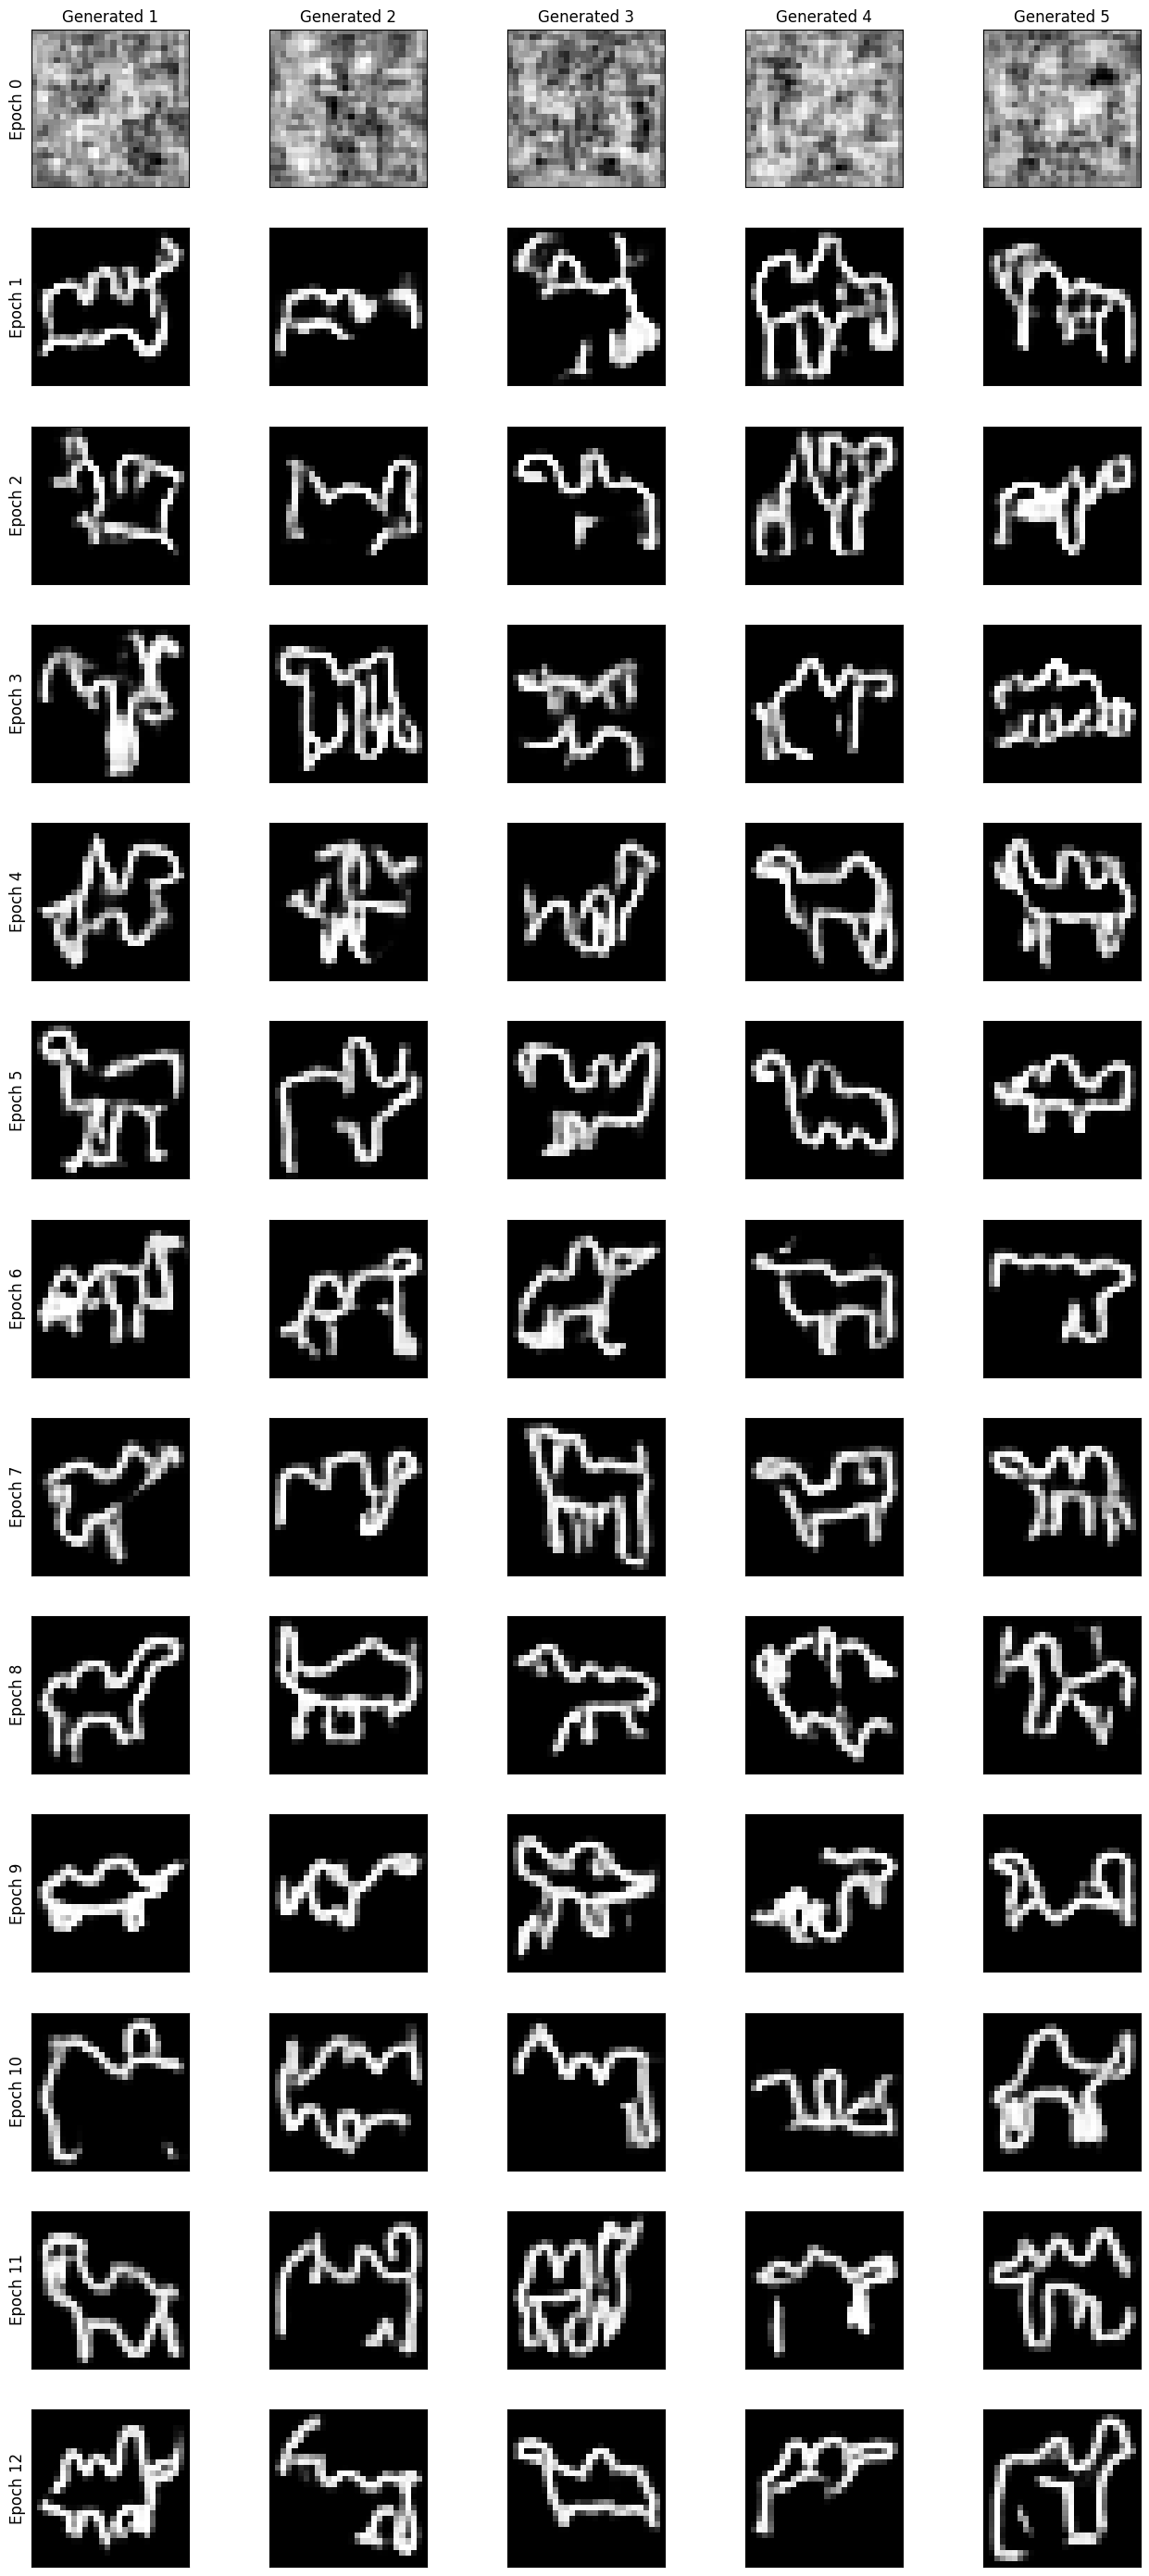

In [ ]:
def plot_images_grid(gen_images, num_to_show=5):
  fig, ax = plt.subplots(len(gen_images), num_to_show, figsize=(13,28))
  fig.tight_layout()

  row_names = [f'Epoch {e}' for e in range(len(gen_images)+1)]
  col_names = [f'Generated {i+1}' for i in range(num_to_show)]
  for a, r in zip(ax[:,0], row_names):
      a.set_ylabel(r, rotation=90, size='large')
  for a, c in zip(ax[0], col_names):
    a.set_title(c)

  for e in range(len(gen_images)):
      for i in range(num_to_show):
          ax[e, i].imshow(gen_images[e][i].squeeze(0).cpu().detach().numpy(), cmap='gray')
          ax[e, i].set_xticks([])
          ax[e, i].set_yticks([])
  
  plt.show()  


plot_images_grid(gen_images_epoch)

# Save/Load the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

torch.save(my_discriminator.state_dict(), '/content/drive/My Drive/Models/WGANGPimals_discriminator_epoch12.model')
torch.save(my_generator.state_dict(), '/content/drive/My Drive/Models/WGANGPimals_generator_epoch12.model')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

disc_conv_filters = [5,5,5,5]
disc_conv_strides = [2,2,2,1]
disc_conv_channels = [64, 64, 128, 128]
disc_conv_padding = [2,1,1,1]
dropout=0.4
disc_in_channels=1
torch.random.manual_seed(10210)

my_discriminator = Discriminator(in_channels=disc_in_channels, 
                                 out_channels=disc_conv_channels, 
                                 disc_conv_filters=disc_conv_filters, 
                                 disc_conv_strides=disc_conv_strides,
                                 disc_conv_padding=disc_conv_padding, 
                                 dropout=dropout)

my_discriminator.load_state_dict(torch.load('/content/drive/My Drive/Models/WGANGPimals_discriminator_epoch12.model', map_location=torch.device('cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_discriminator = my_discriminator.to(device)


gen_conv_filters = [5,5,5,5]
gen_conv_strides = [1,1,1,1]
gen_conv_channels = [128,64,64,1]
gen_conv_padding = [2,2,2,2]
gen_upsample=[2,2,1,1]
gen_dropout=0.4
gen_input_dim=100
gen_momentum=0.9
gen_initial_size=7
torch.random.manual_seed(10210)
my_generator = Generator(input_dim=gen_input_dim, 
                         gen_conv_filters=gen_conv_filters, 
                         gen_conv_strides=gen_conv_strides, 
                         gen_conv_channels=gen_conv_channels, 
                         gen_conv_padding=gen_conv_padding, 
                         gen_upsample=gen_upsample,
                         dropout=gen_dropout,
                         momentum=gen_momentum,
                         initial_image_size=gen_initial_size)


my_generator.load_state_dict(torch.load('/content/drive/My Drive/Models/WGANGPimals_generator_epoch12.model', map_location=torch.device('cpu')))
my_generator = my_generator.to(device)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
